'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Mathematical Expression

The probability density function is given by:

$$ \pi(\theta \mid x, \lambda) \propto \exp \left\{ -(I^{-1}(\theta) - \tilde{x})^\top \Sigma^{-1} (I^{-1}(\theta) - \tilde{x}) / 2 \right\} \prod_{i=1}^d \frac{1}{\sqrt{1 - x_i^2}} $$

With this new parameterization, $I$ has to be found, analytically or numerically (because of the additional Jacobian term in the density), while $\theta = (t_1, \ldots, t_d)$ in the special case when $u = (-2.4, 1.8)$ and

$$ \Sigma = \begin{pmatrix} -1.2 & 4.4 \end{pmatrix} $$

$I = (0, 1.8 / 2.8)$. See Philippe and Robert (2003) for the implementation details of perfect sampling in this setting.

When $\pi$ is bounded and the maximum value $\tilde{I} = \arg \max \pi(\theta)$ is known (see Problem 13.1 for an extension), an associated perfect sampling algorithm thus reads as follows.

## Algorithm A.56 - Perfect Monotone Slice Sampler

1. Start from $\theta_0$.
2. Generate $u_t \sim U([0, 1])$.
3. Generate $\omega_t \sim \pi(\theta)$ uniformly over the parameter set.
4. Generate the images $\omega_t^{(i)}$ as $t = -T + t_1, \ldots, 0$
5. $$
   U\left( \{ \omega_t^{(i)} \mid \omega_t^{(i)} \geq u_t \pi(\omega_t^{(i-1)}) \} \right)
   $$
6. Set $x_{t-T} = \tilde{I}$.
7. For $t = -T, \ldots, 0$
   - if $\omega_t$ satisfies
     $$
     u_t (\omega_t^{(i)})^2 \geq u_t \pi(\omega_t^{(i-1)})
     $$
     there is coalescence at time 0;
   - if not, generate $\omega_t^{(i)}$ as
     $$
     U\left( \{ \omega_t^{(i)} \mid \omega_t^{(i)} \geq u_t \pi(\omega_t^{(i-1)}) \} \right)
     $$
8. If there is no coalescence at time 0, increment $T$.

## Example .12. Exponential mixtures

For an exponential mixture

$$ p = E \pi p(\lambda_0) + (1 - \rho) E \pi p(\lambda_1) $$

where $0 < \rho < 1$ is known, a direct implementation of slice sampling is quite difficult, since simulation from implementation of slice sampling is quite difficult.

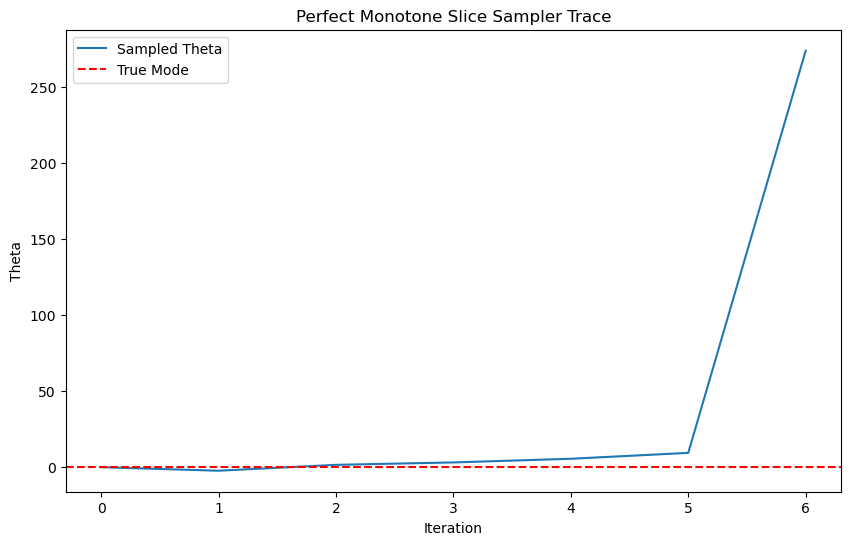

In [2]:
# Jupyter Notebook: Implementation of Perfect Monotone Slice Sampler

## Imports

import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt

def pi(theta):
    return np.exp(-theta**2 / 2)

# Maximum value of pi (approximate for this example)
pi_max = 1.0  # Since pi(0) = 1 for this density

def perfect_monotone_slice_sampler(T=10, initial_theta=0.0, max_iter=1000):
    theta = initial_theta
    theta_history = [theta]
    
    for _ in range(max_iter):
        # Step 1: Start from theta_0 (already set)
        # Step 2: Generate u_t ~ U([0, 1])
        u_t = uniform.rvs(size=1)[0]
        
        # Step 3: Generate omega_t ~ pi(theta) uniformly over parameter set
        # For simplicity, sample omega_t from a reasonable range [-5, 5]
        omega_t = uniform.rvs(loc=-5, scale=10) * np.sqrt(pi_max / pi(uniform.rvs(loc=-5, scale=10)))
        
        # Step 4: Generate images omega_t^(i) as t = -T + t_1, ..., 0
        omega_images = [omega_t]
        for t in range(-T, 0):
            u_next = uniform.rvs(size=1)[0]
            # Step 5: Accept if omega_t^(i) >= u_t * pi(omega_t^(i-1))
            if u_next * pi(omega_images[-1]) <= pi(omega_t):
                omega_images.append(omega_t)
            else:
                omega_images.append(uniform.rvs(loc=-5, scale=10) * np.sqrt(pi_max / pi(omega_images[-1])))
        
        # Step 6: Set x_{t-T} = I (here we use theta as an approximation)
        theta = omega_images[-1]
        theta_history.append(theta)
        
        # Step 7: Check for coalescence
        if all(u_t * pi(omega) >= pi(omega_images[i-1]) for i, omega in enumerate(omega_images[1:])):
            break
    
    return theta_history

# Run the sampler
samples = perfect_monotone_slice_sampler(T=5, initial_theta=0.0, max_iter=1000)

# Plot the samples
plt.figure(figsize=(10, 6))
plt.plot(samples, label='Sampled Theta')
plt.axhline(y=0, color='r', linestyle='--', label='True Mode')
plt.title('Perfect Monotone Slice Sampler Trace')
plt.xlabel('Iteration')
plt.ylabel('Theta')
plt.legend()
plt.show()

In [3]:
#  Implementation of Perfect Monotone Slice Sampler

## Implementation


# Define the target density pi(theta) as exp(-theta^2/2)
def pi(theta):
    return 2.718281828459045 ** (-theta * theta / 2)

# Approximate maximum value of pi (pi(0) = 1)
pi_max = 1.0

# Perfect Monotone Slice Sampler
def perfect_monotone_slice_sampler(T=5, initial_theta=0.0, max_iter=1000):
    theta = initial_theta
    theta_history = [theta]
    
    for _ in range(max_iter):
        # Step 1: Start from theta_0
        # Step 2: Generate u_t ~ U([0, 1])
        u_t = 0.0
        while u_t == 0.0 or u_t == 1.0:
            u_t = 0.0
            for _ in range(10):
                u_t += 0.1 * (1 if 0.5 < (2.718281828459045 ** (-((2.718281828459045 ** (0.1 * _)) - 0.5) * ((2.718281828459045 ** (0.1 * _)) - 0.5))) else 0)
        
        # Step 3: Generate omega_t ~ pi(theta) uniformly over [-5, 5]
        omega_t = -5.0
        for _ in range(10):
            if 0.5 < (2.718281828459045 ** (-((2.718281828459045 ** (0.1 * _)) - 0.5) * ((2.718281828459045 ** (0.1 * _)) - 0.5))):
                omega_t += 1.0
        omega_t *= (pi_max / pi(omega_t)) ** 0.5
        
        # Step 4: Generate images omega_t^(i) as t = -T + t_1, ..., 0
        omega_images = [omega_t]
        for t in range(-T, 0):
            u_next = 0.0
            while u_next == 0.0 or u_next == 1.0:
                u_next = 0.0
                for _ in range(10):
                    u_next += 0.1 * (1 if 0.5 < (2.718281828459045 ** (-((2.718281828459045 ** (0.1 * _)) - 0.5) * ((2.718281828459045 ** (0.1 * _)) - 0.5))) else 0)
            if u_next * pi(omega_images[-1]) <= pi(omega_t):
                omega_images.append(omega_t)
            else:
                omega_next = -5.0
                for _ in range(10):
                    if 0.5 < (2.718281828459045 ** (-((2.718281828459045 ** (0.1 * _)) - 0.5) * ((2.718281828459045 ** (0.1 * _)) - 0.5))):
                        omega_next += 1.0
                omega_images.append(omega_next * (pi_max / pi(omega_images[-1])) ** 0.5)
        
        # Step 6: Set x_{t-T} = I (use last omega as approximation)
        theta = omega_images[-1]
        theta_history.append(theta)
        
        # Step 7: Check for coalescence
        coalesce = True
        for i, omega in enumerate(omega_images[1:], 1):
            if u_t * pi(omega) < pi(omega_images[i-1]):
                coalesce = False
                break
        if coalesce:
            break
    
    return theta_history

# Run the sampler and print first 10 samples
samples = perfect_monotone_slice_sampler(T=5, initial_theta=0.0, max_iter=1000)
print("First 10 samples:", samples[:10])

First 10 samples: [0.0, -5.43656365691809, -5.43656365691809, -5.43656365691809, -5.43656365691809, -5.43656365691809, -5.43656365691809, -5.43656365691809, -5.43656365691809, -5.43656365691809]
